In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join, dirname
import os

import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import itertools
import pickle
import scipy
from IPython.display import display, Markdown, Latex

from plot_utils import lighten_boxplot
import admix

In [2]:
geno_sim_prefix = "EUR_0.2_AFR_0.8_7_80000"
geno_data_dir = f"data/geno/{geno_sim_prefix}/"

In [3]:
anc = np.load(join(geno_data_dir, "anc.npy"))
phgeno = np.load(join(geno_data_dir, "phgeno.npy"))
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))

n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape(n_indiv, n_snp * 2)
phgeno = phgeno.reshape((n_indiv, n_snp * 2))
geno = admix.convert_anc_count(anc=anc, phgeno=phgeno)

# Plotting the allele frequency

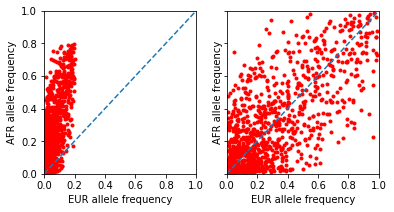

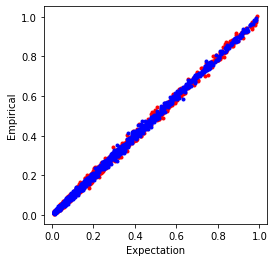

In [4]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
allele_freq = geno.mean(axis=0) / 2
eur_allele_freq = allele_freq[0 : n_snp]
afr_allele_freq = allele_freq[n_snp : (2 * n_snp)]
axs[0].plot(eur_allele_freq, afr_allele_freq , 'r.')
axs[1].plot(legend.EUR.values, legend.AFR.values, 'r.')

for ax_i in range(2):
    axs[ax_i].plot([0, 1], [0,1], '--')
    axs[ax_i].set_xlim(0, 1)
    axs[ax_i].set_ylim(0, 1)
    axs[ax_i].set_xlabel("EUR allele frequency")
    axs[ax_i].set_ylabel("AFR allele frequency")
plt.figure(figsize=(4, 4))
plt.plot(legend.EUR.values, eur_allele_freq / 0.2, 'r.')
plt.plot(legend.AFR.values, afr_allele_freq / 0.8, 'b.')
plt.xlabel("Expectation")
plt.ylabel("Empirical")
plt.show()

In [5]:
control_ratio_list = [1.0, 2.5]
odds_ratio_list = [1.0, 1.15, 1.2, 1.25]
score_df_dict = {control_ratio: dict() for control_ratio in control_ratio_list}

for control_ratio in control_ratio_list:
    rls_dir = f"out/single_snp_test_tractor/{geno_sim_prefix}/0.1_{control_ratio}/"

    for odds_ratio in odds_ratio_list:
        score_df_dict[control_ratio][odds_ratio] = pd.read_csv(join(rls_dir, f"{odds_ratio}_0.0", "summary.csv"))


# Null simulation

## Control ratio: 1.0

ADM              0.034078
ATT              0.049826
MIX              0.049352
SNP1             0.048404
SUM              0.038818
ADM_LOGISTIC     0.048404
ATT_LOGISTIC     0.049510
SNP1_LOGISTIC    0.050406
TRACTOR          0.049299
dtype: float64


## Control ratio: 2.5

ADM              0.034160
ATT              0.052371
MIX              0.052687
SNP1             0.050055
SUM              0.041213
ADM_LOGISTIC     0.049371
ATT_LOGISTIC     0.052266
SNP1_LOGISTIC    0.051424
TRACTOR          0.052424
dtype: float64


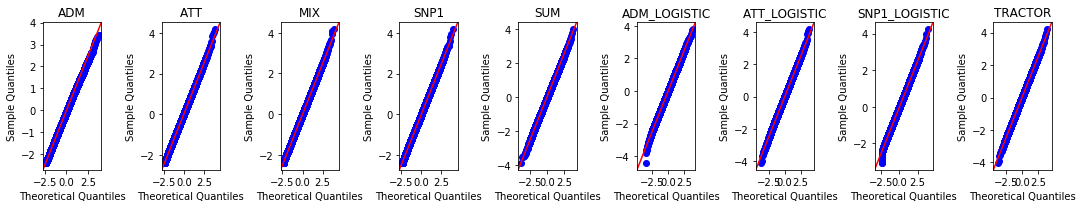

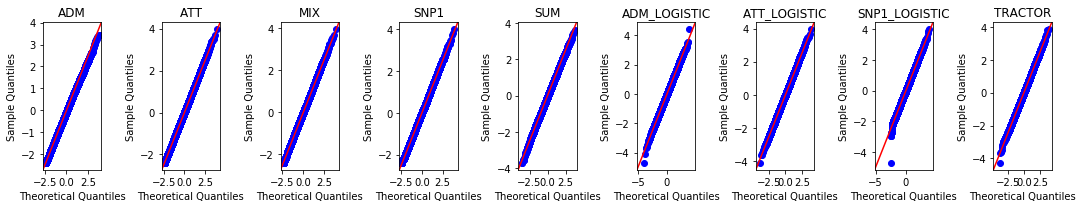

In [6]:
for control_ratio in control_ratio_list:
    display(Markdown(f"## Control ratio: {control_ratio}"))
    score_df = score_df_dict[control_ratio][1.0].copy().dropna()
    pval_df = score_df.iloc[:, 0:-2].copy()

    qq_fig, qq_axs = plt.subplots(1, pval_df.shape[1], figsize=(15,3))
    for col_i, col in enumerate(pval_df.columns):
        zsc = admix.pval2zsc(pval_df[col].values)
        sm.qqplot(zsc, line="45", ax=qq_axs[col_i])
        qq_axs[col_i].set_title(col)
    plt.tight_layout()

    print(np.mean(pval_df < 0.05, axis=0))

# Power in alternative simulation

## Control ratio: 1.0, only differentiated SNPs: False

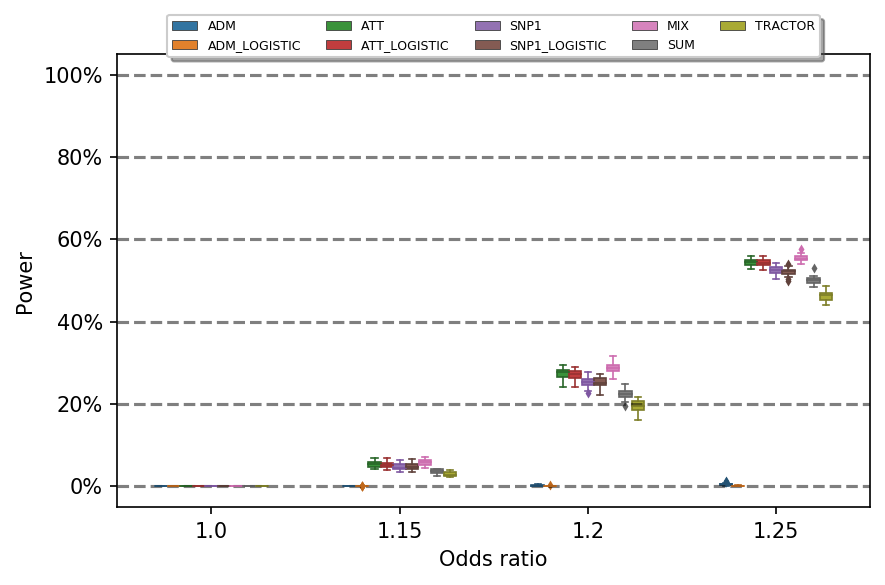

## Control ratio: 1.0, only differentiated SNPs: True

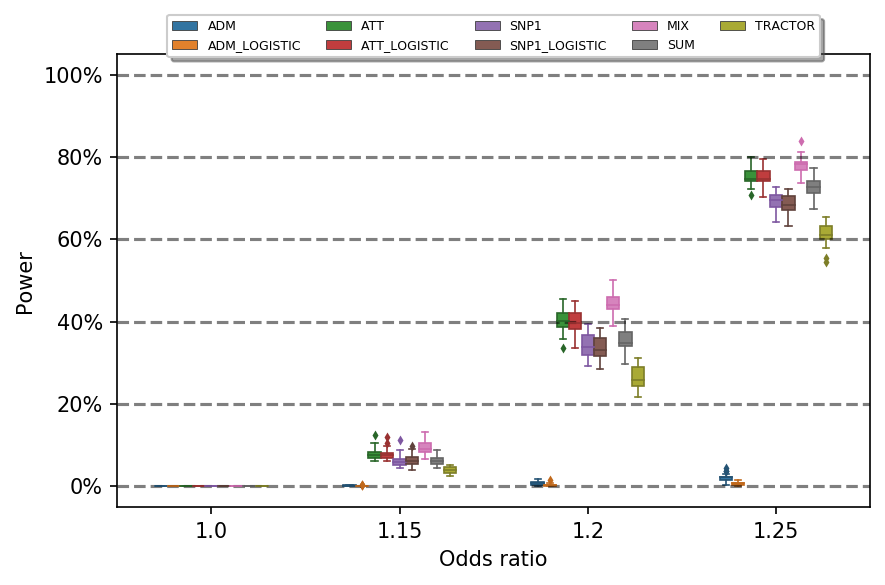

## Control ratio: 2.5, only differentiated SNPs: False

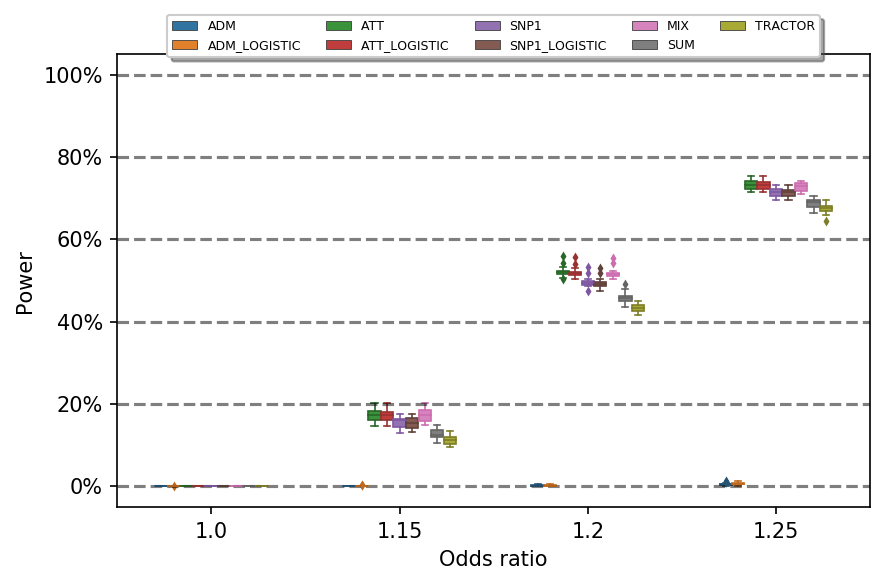

## Control ratio: 2.5, only differentiated SNPs: True

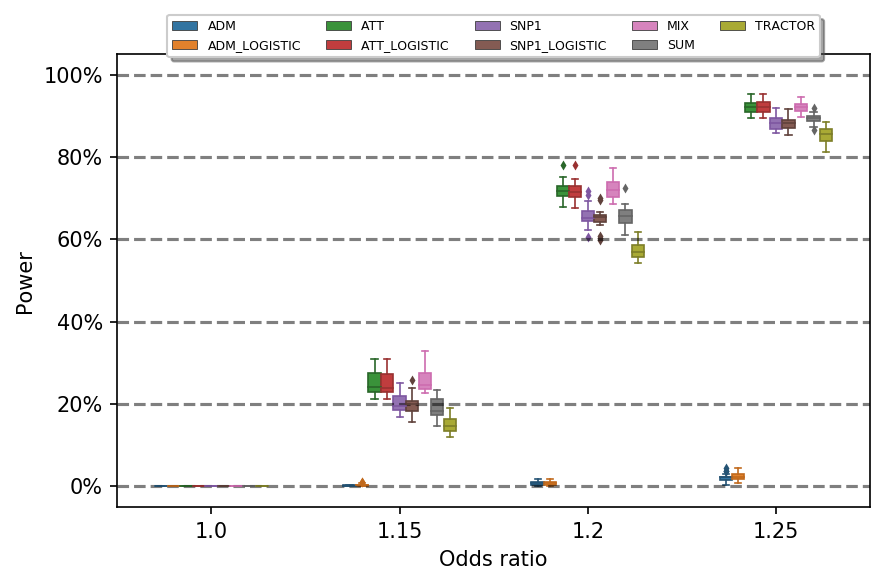

In [7]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]

for control_ratio in control_ratio_list:
    
    
    for only_diff_snp in [False, True]:
        display(Markdown(f"## Control ratio: {control_ratio}, only differentiated SNPs: {only_diff_snp}"))
        df = {"score": [], "odds_ratio": [], "sig_prop": [], "sim_i": []}
        for odds_ratio in odds_ratio_list:
            pval_df = score_df_dict[control_ratio][odds_ratio].copy().dropna()
            if only_diff_snp:
                pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
            for score in pval_df.columns[0:-2]:
                p_threshold = 1e-5 if score in ["ADM", "ADM_LOGISTIC"] else 5e-8
                sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
                sig_prop_mean = np.mean(sig_prop)
                sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
                score_n_sim = len(sig_prop)
                df["score"].extend([score] * score_n_sim)
                df["odds_ratio"].extend([odds_ratio] * score_n_sim)
                df["sig_prop"].extend(sig_prop)
                df["sim_i"].extend(sig_prop.index.values)
        df = pd.DataFrame(df)

        pivotted = df.groupby(["score", "odds_ratio"])["sig_prop"].mean().reset_index().pivot(
            index=["odds_ratio"], columns='score')


        file_prefix = f"{geno_sim_prefix}.control_ratio_{control_ratio}.only_diff" if only_diff_snp else f"{geno_sim_prefix}.control_ratio_{control_ratio}"

        # plotting
        fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
        label_order = ["ADM", "ADM_LOGISTIC", "ATT", "ATT_LOGISTIC", "SNP1", "SNP1_LOGISTIC",
                               "MIX", "SUM", "TRACTOR"]
        sns.boxplot(x="odds_ratio", y="sig_prop",
                    hue="score",
                    hue_order=label_order,
                    width=0.6,
                    linewidth=0.8,
                    fliersize=2,
                    data=df, ax=ax)
        lighten_boxplot(ax)
        [ax.axhline(y=i, linestyle='--', color='k', alpha=0.5) for i in np.linspace(0, 1, 6)]
        ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
        plt.xlabel("Odds ratio")
        plt.ylabel("Power")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=5, fancybox=True, shadow=True, fontsize=6)
        plt.ylim(-0.05, 1.05)
        plt.tight_layout()
        plt.savefig(f"manuscript/power/{file_prefix}.png", dpi=150)
        plt.show()

        pivotted.to_excel(f"manuscript/power/{file_prefix}.xlsx")